In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import time 
import rebound
from celmech.disturbing_function import *
import numpy as np
from celmech.poincare import Poincare, PoincareHamiltonian
from celmech import Andoyer, AndoyerHamiltonian
from celmech.resonances import resonant_period_ratios, resonance_intersections_list, resonance_pratio_span
from rebound.plotting import OrbitPlotOneSlice
import itertools
import time

In [2]:
def findres(sim, i1, i2):
    delta = 0.03
    maxorder = 2
    ps = Poincare.from_Simulation(sim=sim).particles # get averaged mean motions
    n1 = ps[i1].n
    n2 = ps[i2].n
    
    m1 = ps[i1].m
    m2 = ps[i2].m
    
    Pratio = n2/n1
    res = resonant_period_ratios(Pratio-delta,Pratio+delta, order=maxorder)
    
    Z = np.sqrt((ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega))**2 + (ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega))**2)
    
    maxstrength = 0
    j, k, i1, i2, strength = -1, -1, -1, -1, -1
    for a, b in res:
        s = np.abs(np.sqrt(m1+m2)*Z**((b-a)/2.)/(b*n2 - a*n1))
        #print('{0}:{1}'.format(b, a), (b*n2 - a*n1), s)
        if s > maxstrength:
            j = b
            k = b-a
            i1 = 1
            i2 = 2
            strength=s
            maxstrength = s
            
    return j, k, strength

# Modify this function to load your own simulation at the top

In [3]:
def plotecc(ID, tmax=1.e4):
    fig, axarr = plt.subplots(ncols=3, figsize=(12,8))
    file = path+"sa{0:0=7d}.bin".format(ID)
    print(file)
    sa = rebound.SimulationArchive(file)
    sim = sa[0]
    sim.init_megno()
    rebound.OrbitPlot(sim)
    ps = sim.particles
    RH12 = ((ps[1].m+ps[2].m)/3.)**(1./3.)*ps[1].a
    RH23 = ((ps[2].m+ps[3].m)/3.)**(1./3.)*ps[2].a
    Nout = 1000
    times = np.linspace(0, tmax, Nout)
    e1, e2, e3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    a1, a2, a3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    d12, d32 = np.zeros(Nout), np.zeros(Nout)
    a10 = sim.particles[1].a
    a20 = sim.particles[2].a
    a30 = sim.particles[3].a
    print('m', sim.particles[1].m, sim.particles[2].m, sim.particles[3].m)
    print('Pratio', sim.particles[2].P/sim.particles[1].P, sim.particles[3].P/sim.particles[2].P, sim.particles[3].P/sim.particles[1].P)
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
        except:
            print(sim.t)
            break
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        e3[i] = sim.particles[3].e
        a1[i] = sim.particles[1].a
        a2[i] = sim.particles[2].a
        a3[i] = sim.particles[3].a
        de12 = np.sqrt((ps[2].e*np.cos(ps[2].pomega)-ps[1].e*np.cos(ps[1].pomega))**2 + (ps[2].e*np.sin(ps[2].pomega)-ps[1].e*np.sin(ps[1].pomega))**2)
        de32 = np.sqrt((ps[2].e*np.cos(ps[2].pomega)-ps[3].e*np.cos(ps[3].pomega))**2 + (ps[2].e*np.sin(ps[2].pomega)-ps[3].e*np.sin(ps[3].pomega))**2)
        da12 = (ps[2].a-ps[1].a)/ps[1].a
        da32 = (ps[3].a-ps[2].a)/ps[2].a
        d12[i] = (da12-de12)/RH12-1.
        d32[i] = (da32-de32)/RH23-1.
    
    axarr[0].plot(times[e1!=0], e1[e1!=0], label='e1')
    axarr[0].plot(times[e1!=0], e2[e1!=0], label='e2')
    axarr[0].plot(times[e1!=0], e3[e1!=0], label='e3')
    axarr[1].plot(times[e1!=0], (a1[e1!=0]-a10)/a10, label='da1')
    axarr[1].plot(times[e1!=0], (a2[e1!=0]-a20)/a20, label='da2')
    axarr[1].plot(times[e1!=0], (a3[e1!=0]-a30)/a30, label='da3')
    
    if d12[e1!=0].min() < d32[e1!=0].min():
        axarr[2].plot(times[e1!=0], d12[e1!=0], '.', label='d12')
    else:
        axarr[2].plot(times[e1!=0], d32[e1!=0], '.', label='d32')
    
    axarr[1].set_yscale('log')
    axarr[0].legend()
    axarr[1].legend()
    axarr[2].legend()
    
    p1 = np.poly1d(np.polyfit(times[e1!=0], e1[e1!=0], 3))
    p2 = np.poly1d(np.polyfit(times[e1!=0], e2[e1!=0], 3))
    p3 = np.poly1d(np.polyfit(times[e1!=0], e3[e1!=0], 3))

    m1 = p1(times[e1!=0])
    m2 = p2(times[e1!=0])
    m3 = p3(times[e1!=0])
    
    std1 = pd.Series(e1[e1!=0]-m1).std()
    std2 = pd.Series(e2[e1!=0]-m2).std()
    std3 = pd.Series(e3[e1!=0]-m3).std()
    std = max(max(std1, std2), std3)
    
    axarr[0].plot(times[e1!=0], m1)
    axarr[0].plot(times[e1!=0], m2)
    axarr[0].plot(times[e1!=0], m3)
    
    print('std', std1, std2, std3)
    
    da1 = np.median((a1[e1!=0]-a10)/a10)
    da2 = np.median((a2[e1!=0]-a20)/a20)
    da3 = np.median((a3[e1!=0]-a30)/a30)
    
    da = max(max(da1, da2), da3)
    lyap = 1/sim.calculate_lyapunov()
    mind = min(d12[e1!=0].min(), d32[e1!=0].min())
    maxm = max(max(ps[1].m, ps[2].m), ps[3].m)
    print('final time', sim.t)
    rebound.OrbitPlot(sim)
    return axarr, std, da, lyap, mind, maxm, sim

In [12]:
def run(index, tmax=1.e4):
    t0 = time.time()
    file = path+"sa{0:07d}.bin".format(index)
    sim = rebound.Simulation.from_file(file)
    ps = sim.particles
    sim.init_megno()
    
    N = sim.N - sim.N_var
    a0 = [0] + [sim.particles[i].a for i in range(1, N)]
    Npairs = int((N-1)*(N-2)/2)
    js, ks, strengths = np.zeros(Npairs, dtype=np.int), np.zeros(Npairs, dtype=np.int), np.zeros(Npairs)
    maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = -1, -1, -1, -1, -1, -1

    Zcross = np.zeros(Npairs)
    #print('pairindex, i1, i2, j, k, strength')
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        js[i], ks[i], strengths[i] = findres(sim, i1, i2)
        Zcross[i] = (ps[int(i2)].a-ps[int(i1)].a)/ps[int(i1)].a
        #print(i, i1, i2, js[i], ks[i], strengths[i])
        if strengths[i] > maxstrength:
            maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = js[i], ks[i], i1, i2, i, strengths[i]
        
    if maxstrength > 0:
        #print(maxj, maxk, maxi1, maxi2, maxstrength)
        andvars = Andoyer.from_Simulation(sim=sim, j=maxj, k=maxk, a10=a0[maxi1], i1=maxi1, i2=maxi2)
        H = AndoyerHamiltonian(andvars)
        #print(maxj, maxk, maxi1, maxi2, H.state.phi)
    else:
        H = None

    #print('max', maxi1, maxi2, maxj, maxk, maxpairindex, maxstrength)
    #print('df (j, k, pairindex):', df.loc[df.index[index], 'j'], df.loc[df.index[index], 'k'], df.loc[df.index[index], 'pairindex'])

    Nout = 1000
    times = np.linspace(0, tmax, Nout)

    eminus = np.zeros((Npairs, Nout))
    rebound_Z, rebound_phi = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zcom, rebound_phiZcom = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zstar, rebound_dKprime = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    celmech_Z, celmech_phi = np.zeros(Nout), np.zeros(Nout)
    celmech_Zcom, celmech_phiZcom = np.zeros(Nout), np.zeros(Nout)
    celmech_Zstar, celmech_dKprime = np.zeros(Nout), np.zeros(Nout)

    for i,t in enumerate(times):
        for j, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
            i1, i2 = int(i1), int(i2)
            eminus[j, i] = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)
            if js[j] != -1:
                avars = Andoyer.from_Simulation(sim=sim, j=js[j], k=ks[j], a10=a0[i1], i1=i1, i2=i2)
                rebound_Z[j, i] = avars.Z
                rebound_phi[j, i] = avars.phi
                rebound_Zcom[j, i] = avars.Zcom
                rebound_phiZcom[j, i] = avars.phiZcom
                rebound_Zstar[j, i] = avars.Zstar
                rebound_dKprime[j, i] = avars.dKprime
        
        if maxstrength > 0:
            celmech_Z[i] = H.state.Z
            celmech_phi[i] = H.state.phi
            celmech_Zcom[i] = H.state.Zcom
            celmech_phiZcom[i] = H.state.phiZcom
            celmech_Zstar[i] = H.state.Zstar
            celmech_dKprime[i] = H.state.dKprime

            H.integrate(t)
        try:
            sim.integrate(t)
        except:
            break
        
    mask = eminus[0] > 0 # where there are data points in case sim ends early
    times = times[mask]
    eminus = eminus[:, mask]
    rebound_Z, rebound_phi = rebound_Z[:, mask], rebound_phi[:, mask]
    rebound_Zcom, rebound_phiZcom =  rebound_Zcom[:, mask], rebound_phiZcom[:, mask]
    rebound_Zstar, rebound_dKprime = rebound_Zstar[:, mask], rebound_dKprime[:, mask]
    celmech_Z, celmech_phi, celmech_Zcom, celmech_phiZcom = celmech_Z[mask], celmech_phi[mask], celmech_Zcom[mask], celmech_phiZcom[mask]
    celmech_Zstar, celmech_dKprime = celmech_Zstar[mask], celmech_dKprime[mask]
    
    
    return sim, times, maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength, Npairs, js, ks, strengths, eminus, rebound_Z, rebound_phi, rebound_Zcom, rebound_phiZcom, rebound_Zstar, rebound_dKprime, celmech_Z, celmech_phi, celmech_Zcom, celmech_phiZcom, celmech_Zstar, celmech_dKprime, Zcross

# Change path below for where your simulations are stored

In [37]:
path = '/mnt/raid-cita/dtamayo/newstabilitydataset/data/resonant/simulation_archives/runs/'
df = pd.read_csv('../../csvs/resshortfeatures.csv', index_col=0)
df.head()

,runstring,featgentime,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,
0,0000000.bin,2.588877,0.504063,0.594658,0.060234,12.0,1.0,2.0,3.0,0.048244,...,-5.249295e-10,1.471706e-04,0.022954,0.000753,0.144779,0.004245,0.167833,0.001449,0.013174,-0.342356
1,0000001.bin,5.023860,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,0.020943,...,1.420017e-09,9.234751e-05,0.037671,0.001800,0.050951,0.002006,0.027171,0.000309,0.069005,-0.684871
2,0000002.bin,3.386137,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,0.067762,...,9.176673e-11,3.508728e-07,0.427300,0.013722,0.662545,0.019659,0.004258,0.001175,0.020689,0.000014
3,0000003.bin,3.726120,0.406112,1.007603,0.427768,5.0,2.0,1.0,2.0,0.045905,...,5.512634e-08,3.856095e-04,0.837207,0.054084,0.949622,0.048041,0.000000,0.000000,0.081755,0.001596
4,0000004.bin,3.290068,0.059897,0.332922,0.257596,12.0,1.0,1.0,2.0,0.030171,...,-5.059799e-09,1.147590e-03,4.493881,0.296834,5.268717,0.106801,0.000000,0.012919,0.082736,0.000399


# Choose which ID to pass for plotting, as well as the time of the short integration (fFin) and number of output points (Nout). Output the short integration features for that particular system that were generated. 

# THINK ABOUT HOW WELL THEY CAPTURE THE PLOTS BELOW AND HOW WE MIGHT IMPROVE THEM!

In [39]:
ID = 1
tFin,Nout= 1e4,1000
df.loc[ID]

runstring              0000001.bin
featgentime                5.02386
Zcross12                  0.240504
Zcross13                  0.340424
Zcross23                 0.0805473
maxj                             9
maxk                             1
maxi1                            2
maxi2                            3
maxstrength              0.0209427
secondres                0.0321654
tlyap                       692948
EMmed12                  0.0433986
EMmax12                  0.0567273
EMdrift12                 0.420262
capseculartscale12               0
EMdetrendedstd12          0.217071
EMrollingstd12           0.0885484
DiffcoeffEM12         -2.14559e-09
medvarEM12             6.85695e-05
Zmed12                   0.0296283
Zmax12                   0.0426353
Zdetrendedstd12            0.22103
Zrollingstd12            0.0879695
DiffcoeffZ12          -8.02883e-10
medvarZ12              5.28098e-05
Zcomdrift12               0.651907
Zcomrollingstd12         0.0706109
phiZcomdrift12      

# quick summary plot, with panels described in update email to everyone. Middle panel is rms variations in semimajor axes, right is distance from crossing, first orbitplot is initial condition, one at bottom is the final state

/mnt/raid-cita/dtamayo/newstabilitydataset/data/resonant/simulation_archives/runs/sa0000001.bin
('m', 2.065556889998561e-07, 1.6814316545594097e-05, 6.83043088193565e-07)
('Pratio', 1.381636335357751, 1.1232218683548285, 1.5518841459874517)
('std', 0.00036492097440505195, 0.0013499173426479458, 0.0034836708405785446)
('final time', 10000.0)
CPU times: user 1.96 s, sys: 170 ms, total: 2.13 s
Wall time: 2.19 s


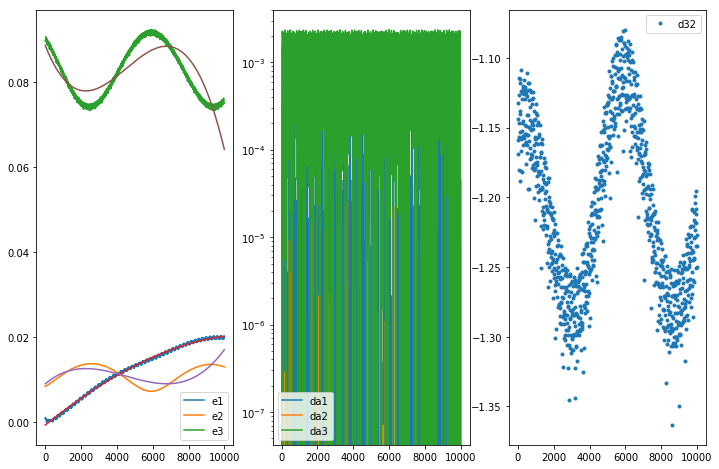

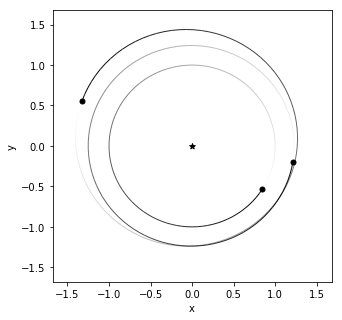

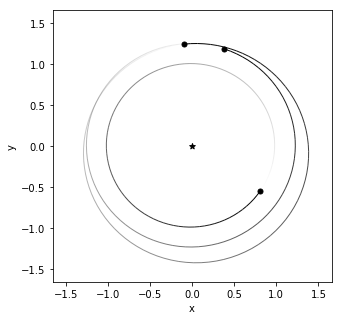

In [15]:
ax, std, da, tlyap, mind, maxm, sim = plotecc(ID, tFin)

In [16]:
%%time
sim, times, maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength, Npairs, js, ks, strengths, eminus, rebound_Z, rebound_phi, rebound_Zcom, rebound_phiZcom, rebound_Zstar, rebound_dKprime, celmech_Z, celmech_phi, celmech_Zcom, celmech_phiZcom, celmech_Zstar, celmech_dKprime, Zcross = run(ID, tFin)

CPU times: user 10.2 s, sys: 0 ns, total: 10.2 s
Wall time: 10.2 s


# This plots Z (approximately the magnitude of the difference between the two eccentricity vectors of each pair of planets), vs the resonant angle for the closest resonance for that particular pair. The strongest resonance among the three planets is additionally overplotted in red using only the celmech model (i.e. only that resonant term in the evolution, not any secular terms or other resonances). The blue is the full Nbody integration. 

# All the Z plots go from 0 to the Z value at which the orbits would cross

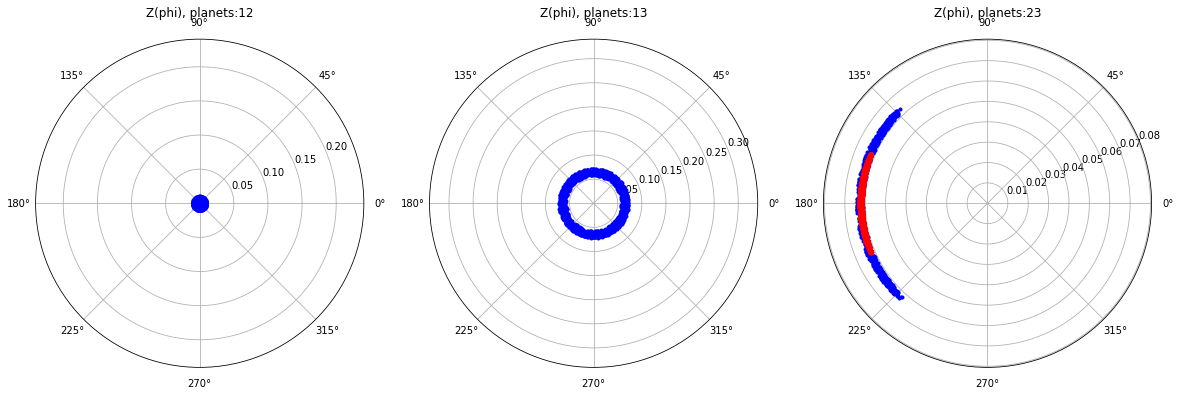

In [17]:
N = sim.N_real
fig, axarr = plt.subplots(figsize=(20,16), ncols=Npairs, subplot_kw=dict(projection='polar'))
for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
    ax = axarr[i]
    ax.set_ylim([0, Zcross[i]])
    ax.set_title('Z(phi), planets:'+str(i1)+str(i2))
    if js[i] != -1:
        ax.plot(rebound_phi[i], rebound_Z[i], 'b.', label='Nbody')
    if maxpairindex != -1:
        axarr[maxpairindex].plot(celmech_phi, celmech_Z, 'r.', label='celmech')

# Z vs time. Blue is Nbody, red is just the resonant terms in celmech

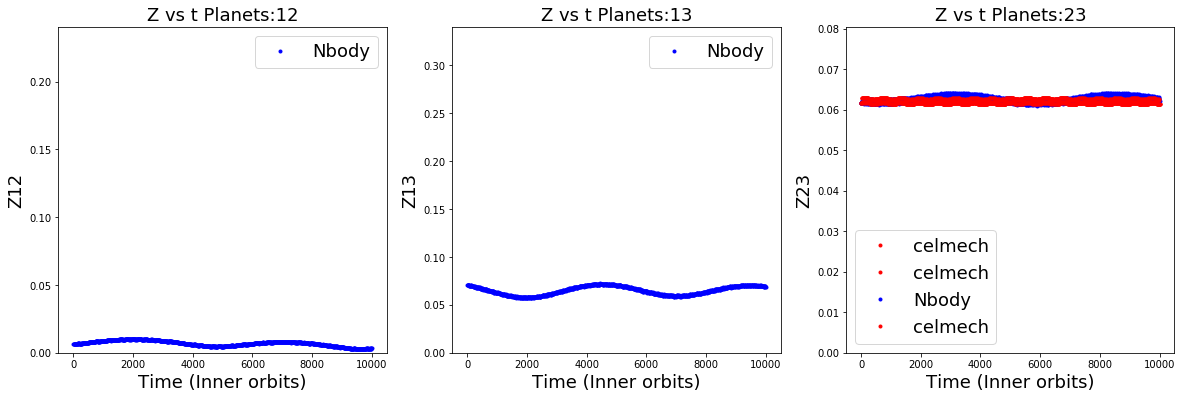

In [49]:
p = np.poly1d(np.polyfit(times, eminus[2], 3))
m = p(times)
fig, axarr = plt.subplots(figsize=(20,6), ncols=Npairs)
for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
    ax = axarr[i]
    ax.set_ylim([0, Zcross[i]])
    ax.set_title('Z vs t Planets:'+str(i1)+str(i2), fontsize=18)
    ax.set_xlabel('Time (Inner orbits)', fontsize=18)
    ax.set_ylabel('Z'+str(i1)+str(i2), fontsize=18)
    #ax.plot(times, eminus[i], 'g.', label='eminus')
    if js[i] != -1:
        ax.plot(times, rebound_Z[i], 'b.', label='Nbody')
    #    ax.plot(times, m, 'c.', label='m')
    if maxpairindex != -1:
        axarr[maxpairindex].plot(times, celmech_Z, 'r.', label='celmech')
        ax.legend(fontsize=18)

# Nbody evolution (blue) and celmech model for the strongest resonance (red) of the ceter of mass eccentricity, which in the 2 planet resonance model would be constant. In the Nbody model it will slowly evolve

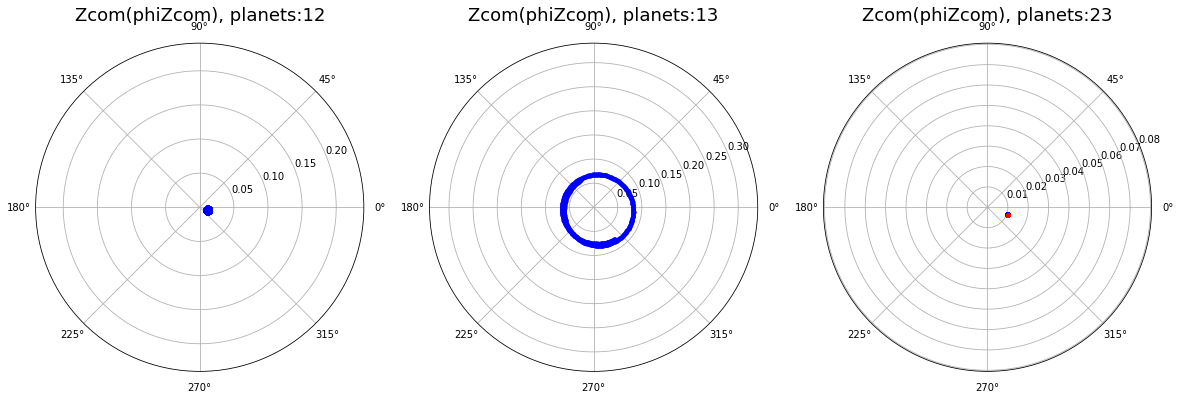

In [19]:
fig, axarr = plt.subplots(figsize=(20,16), ncols=Npairs, subplot_kw=dict(projection='polar'))
for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
    ax = axarr[i]
    ax.set_ylim([0, Zcross[i]])
    ax.set_title('Zcom(phiZcom), planets:'+str(i1)+str(i2), fontsize=18)
    if js[i] != -1:
        ax.plot(rebound_phiZcom[i], rebound_Zcom[i], 'b.', label='Nbody')
if maxpairindex != -1:
    axarr[maxpairindex].plot(celmech_phiZcom, celmech_Zcom, 'r.', label='celmech')

# This unfolds the polar plot above into evoultion of Zcom vs time and the polar angle of Zcom vs time. In the single resonance model again these would be constant. If a plot doesn't show up, it means there was no strong nearby resonance

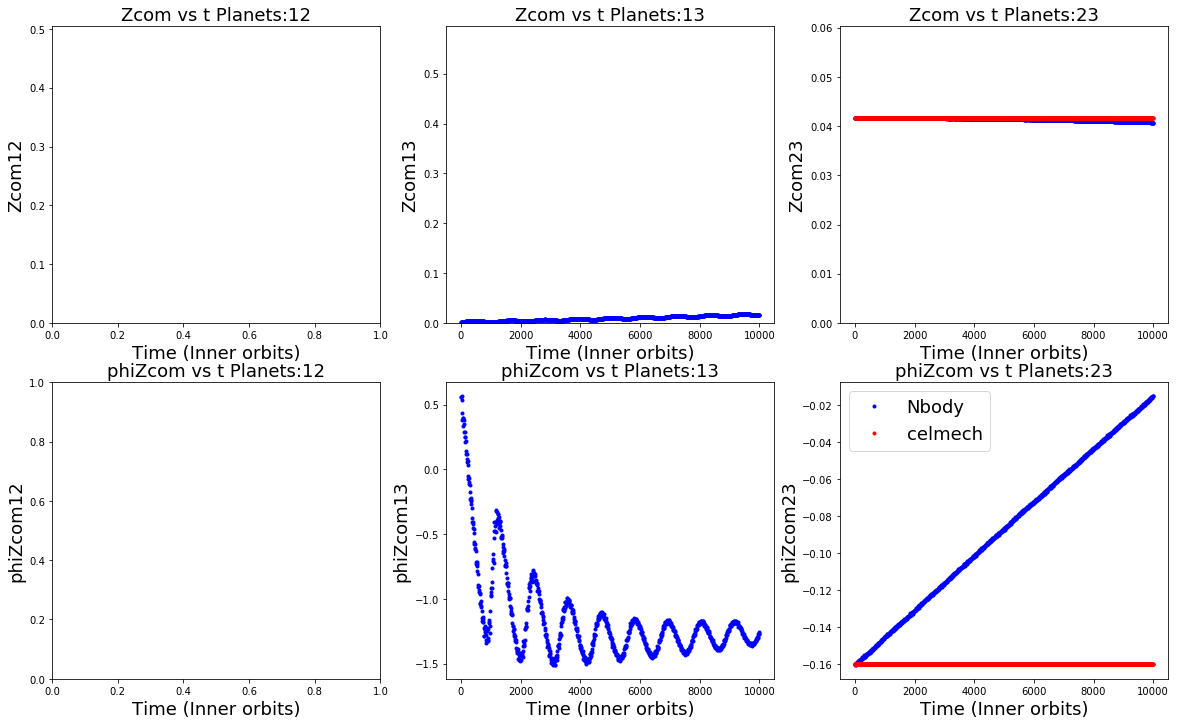

In [20]:
fig, axarr = plt.subplots(figsize=(20,12), ncols=Npairs, nrows=2)
for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
    ax = axarr[0,i]
    ax.set_ylim([0, Zcross[i]])
    ax.set_title('Zcom vs t Planets:'+str(i1)+str(i2), fontsize=18)
    ax.set_xlabel('Time (Inner orbits)', fontsize=18)
    ax.set_ylabel('Zcom'+str(i1)+str(i2), fontsize=18)
    if js[i] != -1:
        ax.plot(times, rebound_Zcom[i], 'b.', label='Nbody')
    
    ax = axarr[1,i]
    ax.set_title('phiZcom vs t Planets:'+str(i1)+str(i2), fontsize=18)
    ax.set_xlabel('Time (Inner orbits)', fontsize=18)
    ax.set_ylabel('phiZcom'+str(i1)+str(i2), fontsize=18)
    if js[i] != -1:
        ax.plot(times, rebound_phiZcom[i], 'b.', label='Nbody')
        
if maxpairindex == i:
    axarr[0,maxpairindex].plot(times, celmech_Zcom, 'r.', label='celmech')
    axarr[1,maxpairindex].plot(times, celmech_phiZcom, 'r.', label='celmech')
ax.legend(fontsize=18)

# Look at system and choose which pair of planets is closets (12) or (23)

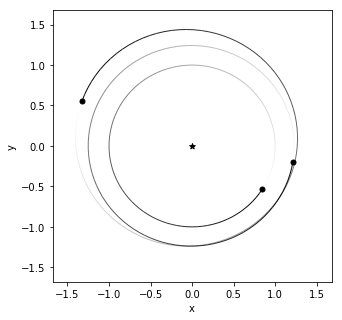

In [26]:
sa = rebound.SimulationArchive(path+"sa{0:0=7d}.bin".format(ID))
sim = sa[0]
fig = rebound.OrbitPlot(sim)

# NOTE: Choose the closest pair to track! closestpair=0 for pair 12, and closestpair=2 for pair 23.

# eminus is simply e2-e1 for a given pair, rather than the exact resonant combination, so it's always well defined even without identifying a particular resonance

In [29]:
closestpair = 0
Z = eminus[closestpair]
Zc = Zcross[closestpair]

# This does not go up to Zcross, to show the variation

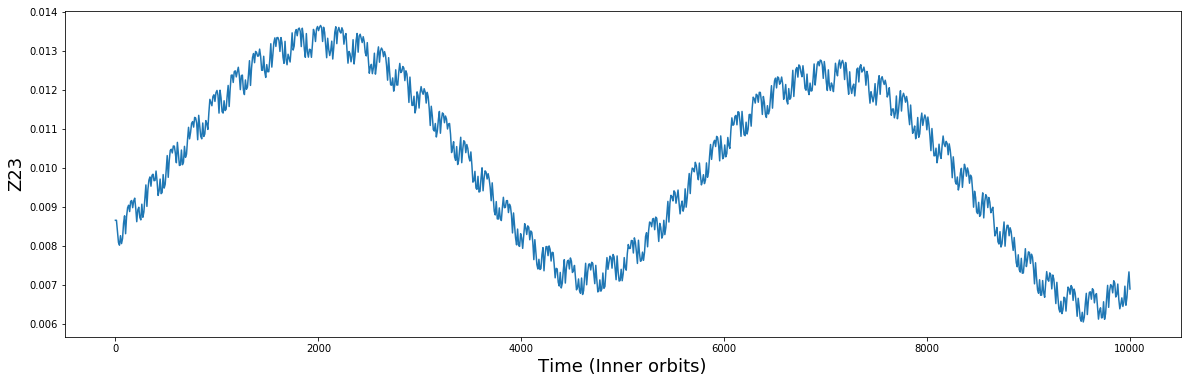

In [32]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(times, Z)
ax.set_xlabel('Time (Inner orbits)', fontsize=18)
ax.set_ylabel('Z'+str(i1)+str(i2), fontsize=18)

# Here is the evolution of the VARIANCE in Z vs time. In a random walk, the variance would grow linearly in time on average, and is what we'd expect in the simplest model for chaotic diffusion. In a periodic signal, you'd expect to variance to grow initially and plateau after a timescale given by the main oscillation period.

# HOW DO WE GENERATE A GOOD FEATURE FOR DISTINGUISHING BETWEEN THESE TWO BEHAVIORS?

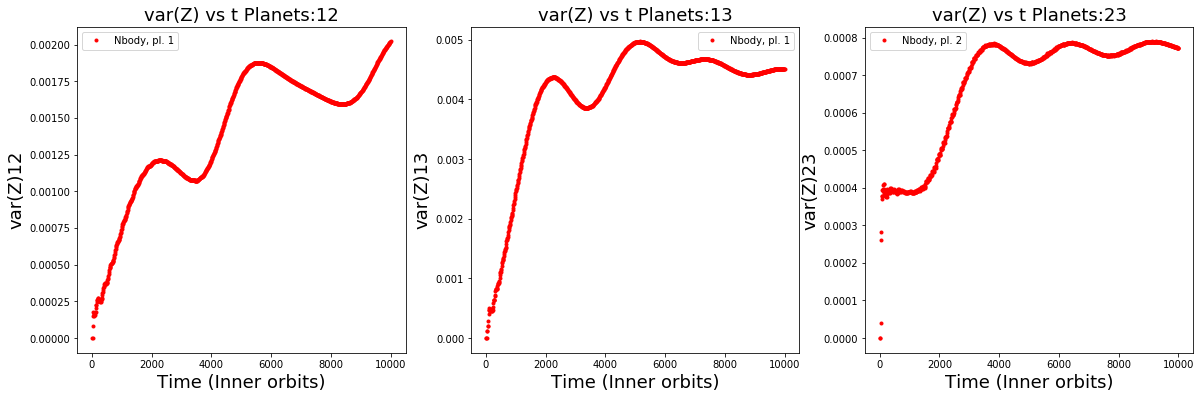

In [34]:
fig, axarr = plt.subplots(figsize=(20,6), ncols=Npairs)
for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
    vals = rebound_Z[i]
    std = [vals[:j].std() for j in range(len(vals))]
    ax = axarr[i]
    #ax.set_ylim([0, Zcross[i]])
    ax.set_title('var(Z) vs t Planets:'+str(i1)+str(i2), fontsize=18)
    ax.set_xlabel('Time (Inner orbits)', fontsize=18)
    ax.set_ylabel('var(Z)'+str(i1)+str(i2), fontsize=18)
    if js[i] != -1:
        ax.plot(times, std, 'r.', label='Nbody, pl. %d'%(i1))
    ax.legend()

# This is the evolution in time of the two other conserved quantities in the 2 planet resonance model. Zstar is the center of the resonance, i.e., if you started the system at Zstar with a resonance angle of pi, then Z should not evolve at all. Additional terms (secular, other resonances) will cause Zstar to slowly change. dKprime relates the variations between the semimajor axes of the two resonant planets. 

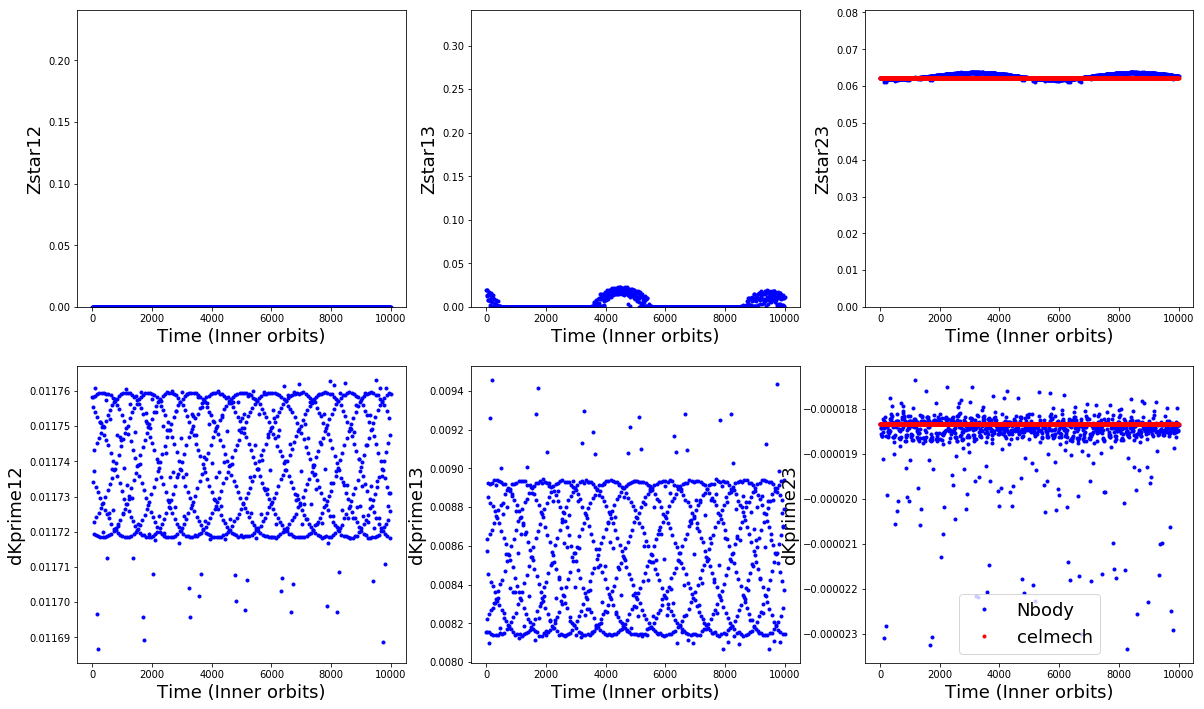

In [35]:
fig, axarr = plt.subplots(figsize=(20,12), ncols=Npairs, nrows=2)
for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
    ax = axarr[0,i]
    ax.set_ylim([0, Zcross[i]])
    ax.set_xlabel('Time (Inner orbits)', fontsize=18)
    ax.set_ylabel('Zstar'+str(i1)+str(i2), fontsize=18)
    if js[i] != -1:
        ax.plot(times, rebound_Zstar[i], 'b.', label='Nbody')
    
    ax = axarr[1,i]
    ax.set_xlabel('Time (Inner orbits)', fontsize=18)
    ax.set_ylabel('dKprime'+str(i1)+str(i2), fontsize=18)
    if js[i] != -1:
        ax.plot(times, rebound_dKprime[i], 'b.', label='Nbody')
        
if maxpairindex == i:
    axarr[0,maxpairindex].plot(times, celmech_Zstar, 'r.', label='celmech')
    axarr[1,maxpairindex].plot(times, celmech_dKprime, 'r.', label='celmech')
ax.legend(fontsize=18)

# Check how the Nbody evolution compares to just the secular evolution without any resonant terms

In [44]:
sa = rebound.SimulationArchive(path+"sa{0:0=7d}.bin".format(ID))
sim = sa[0]

pvars = Poincare.from_Simulation(sim)
Hsim = PoincareHamiltonian(pvars)
Nbodies = Hsim.state.N
expand_order=2
for i in range(1,Nbodies):
    for j in range(i+1,Nbodies):
        Hsim.add_secular_terms(i,j,expand_order)
Hsim.set_secular_mode()

Computing secular expansion to order 2...


In [45]:
%%time
tFin,Nout= 1e4,1000
times= np.linspace(0,tFin,Nout)
rebound_ecc = np.zeros((3,Nout))
celmech_ecc = np.zeros((3,Nout))
for i,t in enumerate(times):
    for j in range(1,sim.N):
        celmech_ecc[j-1,i] = Hsim.state.particles[j].e
        rebound_ecc[j-1,i] = sim.particles[j].e
    Hsim.integrate(t)
    sim.integrate(t)

CPU times: user 1.03 s, sys: 2 ms, total: 1.03 s
Wall time: 1.03 s


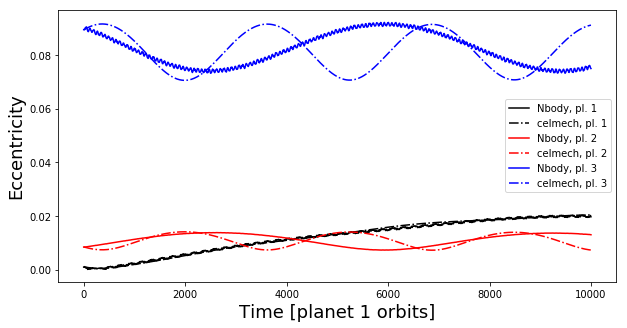

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(1,figsize=(10,5))
for i,col in enumerate(['k','r','b']):
    ax.plot(times,rebound_ecc[i],'%s'%col,label='Nbody, pl. %d'%(i+1))
    ax.plot(times,celmech_ecc[i],'%s-.'%col,label='celmech, pl. %d'%(i+1))

ax.set_xlabel('Time [planet 1 orbits]',fontsize=18)
ax.set_ylabel('Eccentricity',fontsize=18)
ax.legend()

# Old function to test how well findres finds the resonance that was used in generating the resonant dataset for making a particular system. Need to rewrite to work

In [187]:
total = 100
firstordermatches = 0
secondordermatches = 0
firstordertotal = 0
secondordertotal = 0

for ID in range(total):
    pairindex, j, k, i1, i2 = findres(ID)
    #print('\nMax = ', pairindex, j, k)
    row = df.loc[ID]
    if row['k'] == 1:
        firstordertotal += 1
        if row['pairindex'] == pairindex and row['j'] == j and row['k'] == k:
            firstordermatches += 1
        else:
            print(ID, k, j/float(j-k), pairindex, row['pairindex'])
    elif row['k'] == 2:
        secondordertotal += 1
        if row['pairindex'] == pairindex and row['j'] == j and row['k'] == k:
            secondordermatches += 1
        else:
            print(ID, k, j/float(j-k), pairindex, row['pairindex'])

1 1 1.125 1 1
7 1 1.33333333333 2 0
9 1 1.5 0 1
11 1 1.33333333333 1 0
12 1 1.2 0 1
13 1 1.16666666667 0 1
16 1 2.0 0 1
19 1 1.16666666667 1 0
20 1 1.0625 1 0
22 1 2.0 1 0
27 1 1.125 1 2
41 1 1.5 0 1
43 1 2.0 2 1
45 1 1.16666666667 0 1
47 1 2.0 2 0
48 1 1.11111111111 0 0
50 1 1.16666666667 1 1
51 1 1.25 0 1
53 1 2.0 2 1
58 1 2.0 1 0
61 1 2.0 1 0
65 1 2.0 2 1
69 2 1.66666666667 1 0
74 1 1.5 1 0
77 1 1.33333333333 0 1
84 1 1.25 0 1
89 2 1.4 1 0
92 1 1.125 1 0
99 1 1.5 0 1


In [68]:
print(firstordertotal, secondordertotal)

524 475


In [69]:
firstordermatches/float(firstordertotal)

In [70]:
secondordermatches/float(secondordertotal)